In [1]:
import pandas as pd

PATH = "data files/trialdata_testing_seconddisplayonly.tsv"

df = pd.read_csv(
    PATH,
    sep="\t",
    encoding="utf-16",
    nrows=5  # only load a few rows
)

print("\n=== Columns that might be reaction time ===\n")

for col in df.columns:
    name = col.lower()
    if any(k in name for k in ["rt", "reaction", "time", "latency"]):
        print(f"{col}")
        print(" sample values:", df[col].values)
        print("-" * 40)



=== Columns that might be reaction time ===

EYE_REPORTED
 sample values: ['LEFT' 'LEFT' 'LEFT' 'LEFT' 'LEFT']
----------------------------------------
FIXATION_DURATION_MAX_TIME
 sample values: [2144427. 2154173. 2162048. 2169910. 2178515.]
----------------------------------------
FIXATION_DURATION_MIN_TIME
 sample values: [2145084. 2154592. 2161767. 2169614. 2179015.]
----------------------------------------
PUPIL_SIZE_MAX_TIME
 sample values: [2145182. 2153639. 2161841. 2170854. 2178522.]
----------------------------------------
PUPIL_SIZE_MIN_TIME
 sample values: [2144106. 2154594. 2162257. 2169910. 2178899.]
----------------------------------------
REACTION_TIME
 sample values: ['.' '.' '.' '.' '.']
----------------------------------------


In [7]:
import json
import numpy as np
import pandas as pd

PATH = "Testing/testing.json"

with open(PATH, "r") as f:
    data = json.load(f)

print("Loaded trials:", len(data))


Loaded trials: 2304


In [ ]:
# Reaction Time Extraction from JSON (Testing)

import json
import numpy as np
import pandas as pd

# Path (CONFIRMED from your tree)
PATH = "Testing/testing.json"

# Load JSON
with open(PATH, "r") as f:
    data = json.load(f)

print(f"[OK] Loaded {len(data)} trials from {PATH}")

# Compute RT per trial
rows = []

for trial in data:
    onset = trial.get("test_image_on_ms")
    fix_starts = trial.get("fix_start_ms")

    if onset is None or fix_starts is None:
        rt = np.nan
    else:
        fix_starts = np.asarray(fix_starts, dtype=float)
        post_onset = fix_starts[fix_starts >= onset]

        # RT = first fixation AFTER test image onset
        rt = post_onset[0] - onset if len(post_onset) > 0 else np.nan

    rows.append({
        "subject_id": trial.get("subject_id"),
        "trial_index": trial.get("trial_index"),
        "viewing": trial.get("viewing_condition"),
        "RT_ms": rt,
        "accuracy": trial.get("acc"),
        "first_image": trial.get("first_image"),
        "second_image": trial.get("second_image"),
    })

df_rt = pd.DataFrame(rows)

# Sanity filtering (recommended)
# Remove anticipatory + extreme RTs
df_rt = df_rt[
    (df_rt["RT_ms"].isna()) |
    ((df_rt["RT_ms"] >= 100) & (df_rt["RT_ms"] <= 3000))
]

# Quick diagnostics
print("\nRT summary:")
print(df_rt["RT_ms"].describe())

print("\nTrials with valid RT:", df_rt["RT_ms"].notna().sum())


[OK] Loaded 2304 trials from Testing/testing.json

RT summary:
count    1791.000000
mean      290.676159
std       172.553737
min       100.000000
25%       188.000000
50%       247.000000
75%       324.500000
max      1672.000000
Name: RT_ms, dtype: float64

Trials with valid RT: 1791

[OK] Saved → kde_outputs/testing_trial_level_rt.csv


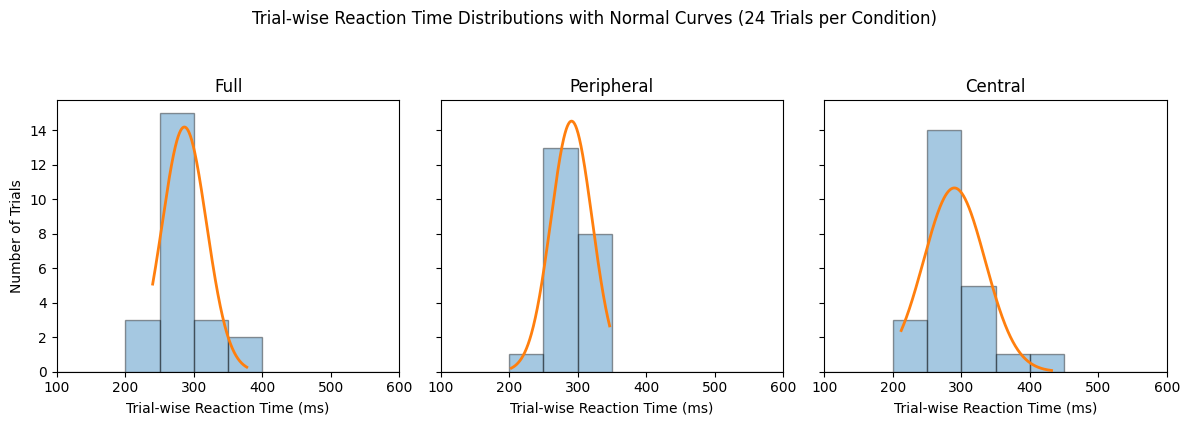

In [ ]:
# Trial-wise Reaction Time Histograms + Normal Curves

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load RT data (already computed)
df = pd.read_csv("kde_outputs/testing_trial_level_rt.csv")

# Keep valid RTs only
df = df[df["RT_ms"].notna()]

# Create within-viewing trial index (1–24)
df = df.sort_values(
    ["subject_id", "viewing", "trial_index"]
)

df["trial_in_viewing"] = (
    df
    .groupby(["subject_id", "viewing"])
    .cumcount() + 1
)

# Trial-wise RT (24 per condition)
trialwise_rt = (
    df
    .groupby(["viewing", "trial_in_viewing"])
    .agg(trial_rt=("RT_ms", "mean"))
    .reset_index()
)

# Plot settings
bins = np.arange(100, 601, 50)
bin_width = bins[1] - bins[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ax, cond, title in zip(
    axes,
    ["full", "peripheral", "central"],
    ["Full", "Peripheral", "Central"]
):
    data = trialwise_rt[
        trialwise_rt["viewing"] == cond
    ]["trial_rt"]

    # Histogram as counts
    ax.hist(
        data,
        bins=bins,
        density=False,
        alpha=0.4,
        edgecolor="black"
    )

    # Normal curve scaled to counts
    mu, sigma = norm.fit(data)
    x = np.linspace(data.min(), data.max(), 300)
    y = norm.pdf(x, mu, sigma)
    y_scaled = y * len(data) * bin_width

    ax.plot(x, y_scaled, linewidth=2)

    ax.set_title(title)
    ax.set_xlabel("Trial-wise Reaction Time (ms)")
    ax.set_xlim(100, 600)

axes[0].set_ylabel("Number of Trials")

plt.suptitle(
    "Trial-wise Reaction Time Distributions with Normal Curves (24 Trials per Condition)",
    y=1.05
)

plt.tight_layout()
plt.show()


In [12]:
trialwise_rt.groupby("viewing").size()


viewing
central       24
full          23
peripheral    22
dtype: int64

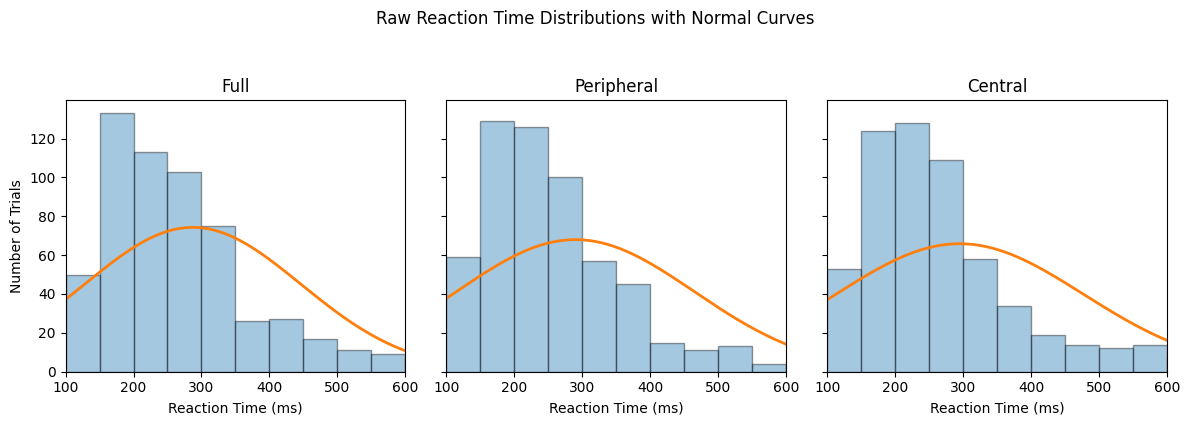

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load raw RT data
df = pd.read_csv("kde_outputs/testing_trial_level_rt.csv")

# Keep valid RTs only
df = df[df["RT_ms"].between(100, 3000)]

# Plot settings
bins = np.arange(100, 1001, 50)
bin_width = bins[1] - bins[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ax, cond, title in zip(
    axes,
    ["full", "peripheral", "central"],
    ["Full", "Peripheral", "Central"]
):
    data = df[df["viewing"] == cond]["RT_ms"]

    # Histogram as COUNTS (same as before)
    ax.hist(
        data,
        bins=bins,
        density=False,
        alpha=0.4,
        edgecolor="black"
    )

    # Normal curve (scaled to counts)
    mu, sigma = norm.fit(data)
    x = np.linspace(data.min(), data.max(), 300)
    y = norm.pdf(x, mu, sigma)
    y_scaled = y * len(data) * bin_width

    ax.plot(x, y_scaled, linewidth=2)

    ax.set_title(title)
    ax.set_xlabel("Reaction Time (ms)")
    ax.set_xlim(100, 600)

axes[0].set_ylabel("Number of Trials")

plt.suptitle(
    "Raw Reaction Time Distributions with Normal Curves",
    y=1.05
)

plt.tight_layout()
plt.show()


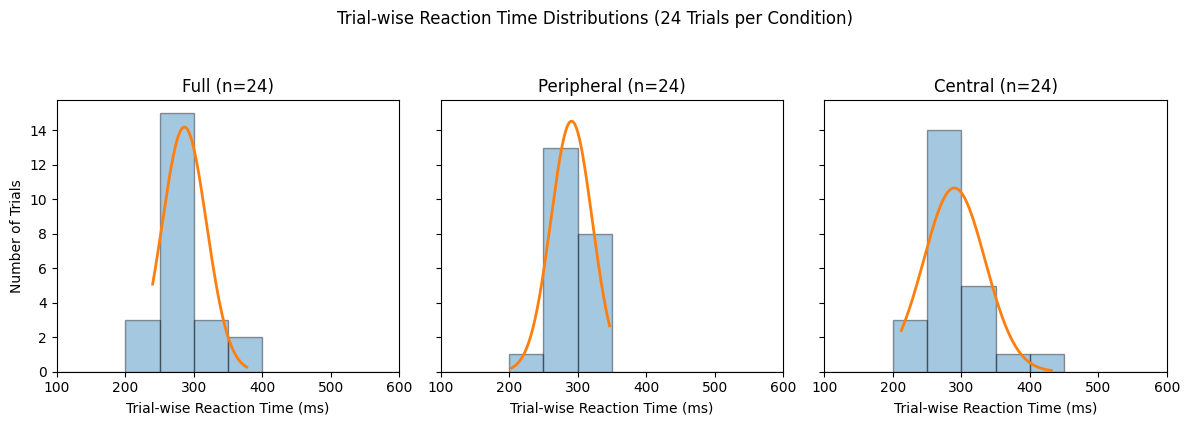

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load raw RT data
df = pd.read_csv("kde_outputs/testing_trial_level_rt.csv")
df = df[df["RT_ms"].between(100, 3000)]

# Create trial_in_viewing
df = df.sort_values(["subject_id", "viewing", "trial_index"])
df["trial_in_viewing"] = (
    df.groupby(["subject_id", "viewing"]).cumcount() + 1
)

# Trial-wise mean RT
trialwise = (
    df.groupby(["viewing", "trial_in_viewing"])
      .agg(trial_rt=("RT_ms", "mean"))
      .reset_index()
)

# FORCE 24 trials per condition
full_index = pd.MultiIndex.from_product(
    [["full", "peripheral", "central"], range(1, 25)],
    names=["viewing", "trial_in_viewing"]
)

trialwise = (
    trialwise
    .set_index(["viewing", "trial_in_viewing"])
    .reindex(full_index)
    .reset_index()
)

# Plot settings
bins = np.arange(100, 601, 50)
bin_width = bins[1] - bins[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ax, cond, title in zip(
    axes,
    ["full", "peripheral", "central"],
    ["Full", "Peripheral", "Central"]
):
    data = trialwise[
        trialwise["viewing"] == cond
    ]["trial_rt"]

    # Histogram (NaNs automatically ignored by matplotlib)
    ax.hist(
        data,
        bins=bins,
        density=False,
        alpha=0.4,
        edgecolor="black"
    )

    # Normal curve (fit only on valid data)
    valid = data.dropna()
    mu, sigma = norm.fit(valid)
    x = np.linspace(valid.min(), valid.max(), 300)
    y = norm.pdf(x, mu, sigma)
    y_scaled = y * len(valid) * bin_width

    ax.plot(x, y_scaled, linewidth=2)

    ax.set_title(f"{title} (n=24)")
    ax.set_xlabel("Trial-wise Reaction Time (ms)")
    ax.set_xlim(100, 600)

axes[0].set_ylabel("Number of Trials")

plt.suptitle(
    "Trial-wise Reaction Time Distributions (24 Trials per Condition)",
    y=1.05
)

plt.tight_layout()
plt.show()
